Check burst dynamics with filtration method.  
Run [extract_burstprops.py](extract_burstprops.py) first

In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

import sys
sys.path.append("/home/jungyoung/Project/hh_neuralnet/include/")
import hhsignal
import hhtools

from numba import jit
import burst.burst_tools as bt


summary_obj = hhtools.SummaryLoader("./data")

def load_bprops(cid):
    fname = "./postdata/bprops_%d.pkl"%(cid)
    with open(fname, "rb") as fp:
        data = pkl.load(fp)
    # print(data["attrs"])
    return data['burst_props'], data["attrs"]
    

def load_amprange(cid):
    famp_range = "../extract_osc_motif/data/osc_motif/amp_range_set.pkl"
    with open(famp_range, "rb") as fp:
        amp_range = pkl.load(fp)["amp_range_set"][cid-1]
    return amp_range


In [2]:
cid = 7
nt_target = 15

bprops, meta = load_bprops(cid)
details = summary_obj.load_detail(cid-1, nt_target)
amp_range = load_amprange(cid)
ramp_range = bt.resize_amp_range(amp_range)

with open("../extract_osc_motif/data/osc_motif/motif_info_%d.pkl"%(cid), "rb") as fp:
    winfo = pkl.load(fp)["winfo"]

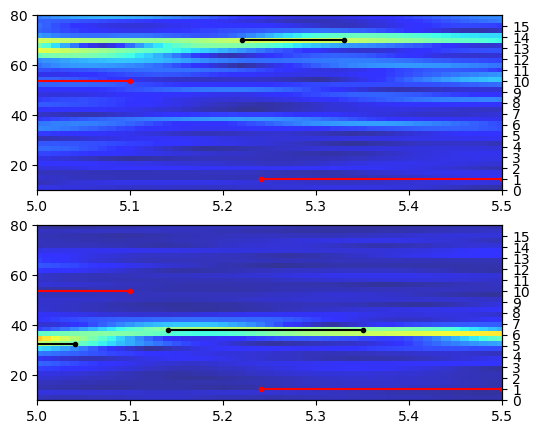

In [3]:
l_subset = [[], []]

plt.figure(figsize=(6, 5))
for npop in range(2):
    
    plt.subplot(2,1,npop+1)
    
    psd, fpsd, tpsd = hhsignal.get_stfft(details["vlfp"][npop+1], details["ts"], 2000, frange=(10, 100), wbin_t=0.5, mbin_t=0.01)
    plt.imshow(psd, extent=(tpsd[0], tpsd[-1], fpsd[0], fpsd[-1]), aspect="auto", cmap="jet", origin="lower", alpha=0.8)
    
    N = len(bprops[npop]["id_trial"])
    for n, nt in enumerate(bprops[npop]["id_trial"]):
        if nt != nt_target:
            continue
        
        r = bprops[npop]["burst_range"][n]
        f = bprops[npop]["burst_f"][n]
        tr = [bprops[npop]["tpsd"][int(i)] for i in r]
    
        plt.plot(tr, [f, f], "k.-")
        
        # if tr[0] > 1 and tr[1] < 2:
        #     print(f"{n}, {f}, {r}")
        
        l_subset[npop].append(r[1]-r[0])
    
    plt.ylim([10, 80])
    plt.xlim([5, 5.5])
    
    plt.twinx()
    for i in range(1, 16):
        for nt, tl in winfo[i]:
            if nt != nt_target:
                continue
                
            plt.plot(tl, [i, i], 'r.-')
    plt.ylim([0, 16])
    plt.yticks(np.arange(16))
    # plt.grid(True)
    
plt.show()

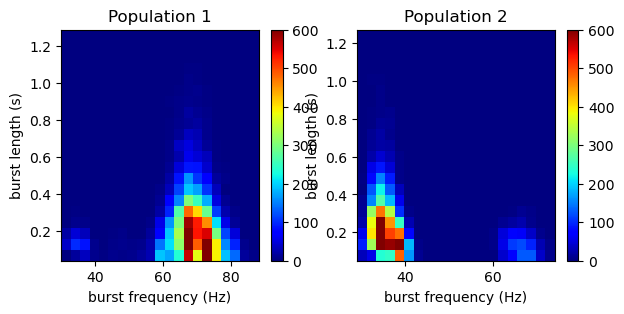

In [4]:
# show bprops
plt.figure(figsize=(7, 3))
for npop in range(2):
    dt = bprops[npop]["tpsd"][10] - bprops[npop]["tpsd"][9]
    l = bprops[npop]["burst_range"] * dt
    l = l[:,1] - l[:,0]
    
    plt.subplot(1, 2, npop+1)
    plt.hist2d(bprops[npop]['burst_f'], l, 21, vmax=600, cmap="jet")
    plt.xlabel("burst frequency (Hz)")
    plt.ylabel("burst length (s)")
    plt.title("Population %d"%(npop+1))
    plt.colorbar()
plt.show()

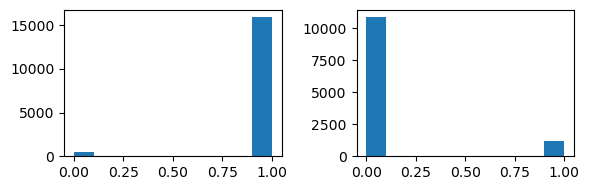

In [5]:
for npop in range(2):
    bt.identify_burst_fid(bprops[npop], ramp_range[npop])
    bprops[npop]["bf_range"] = ramp_range[npop]
    
plt.figure(figsize=(6, 2))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.hist(bprops[i]["burst_fid"])
plt.tight_layout()
plt.show()

# Combined MFOPs

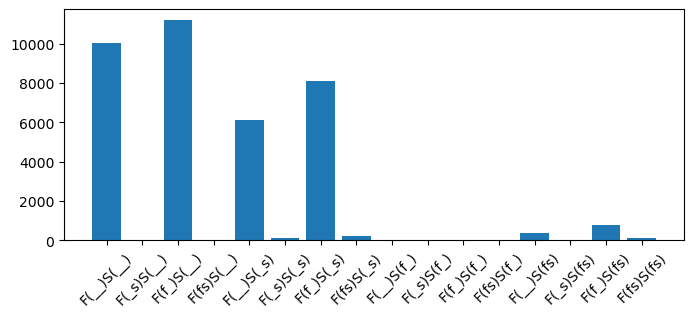

In [9]:
sys.path.append("/home/jungyoung/Project/hh_neuralnet/extract_osc_motif/")
import oscdetector as od

with open("./postdata/mfop/spec_summary/spectrum_%d.pkl"%(cid), "rb") as fp:
    spec_summary = pkl.load(fp)
    
with open("./postdata/mfop/motif_info_%d.pkl"%(cid), "rb") as fp:
    motif_info = pkl.load(fp)["winfo"]
    
plt.figure(figsize=(8, 3))
plt.bar(np.arange(16), [len(motif_info[i]) for i in range(16)])
plt.xticks(np.arange(16), labels=od.get_motif_labels(), rotation=45)
plt.show()

## Visualize spec summary

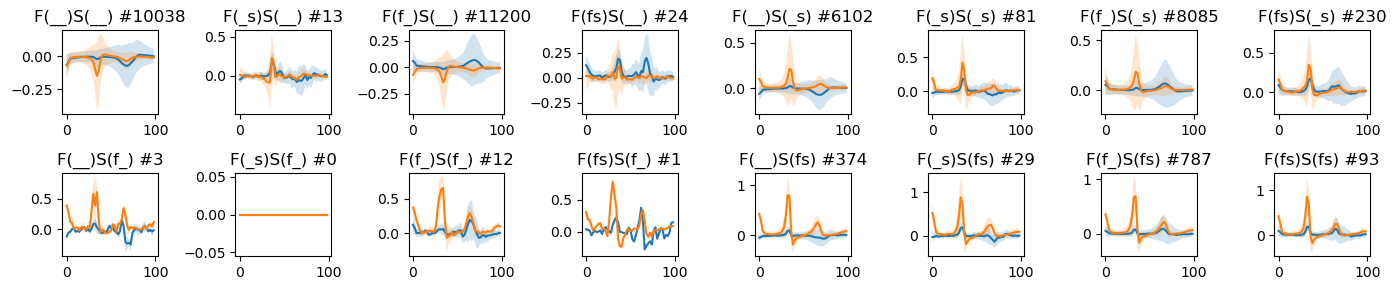

In [22]:
labels = od.get_motif_labels()
fpsd = spec_summary["fpsd"]

plt.figure(figsize=(14, 3))
for i in range(16):
    plt.subplot(2, 8, i+1)
    for j in range(2):
        m = spec_summary["spectrum_avg"][i,j,:]
        s = np.sqrt(spec_summary["spectrum_var"][i,j,:])
        # c = 1.96 * s / np.sqrt(spec_summary["npoints"][i]) / 2
        c = 1.96 * s / 2
        plt.plot(fpsd, m)
        plt.fill_between(fpsd, m-c, m+c, alpha=0.2)
    plt.title(f"{labels[i]} #{len(motif_info[i])}")
    
plt.tight_layout()
plt.show()

## visualize locations

(6.0, 7.0)

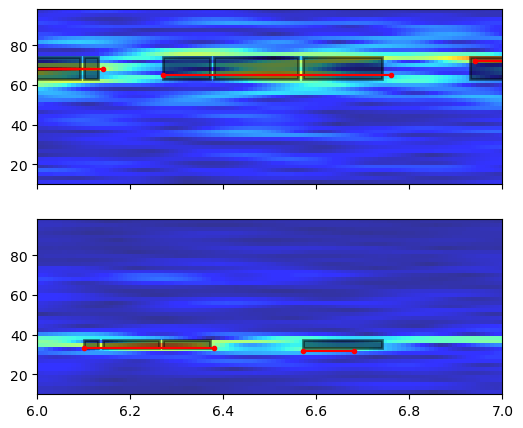

In [17]:

import matplotlib.patches as patches


summary_obj =  hhtools.SummaryLoader("./data")

fs = 2000
nt_target = 1

detail_data = summary_obj.load_detail(cid-1, nt_target)
        
# compute stfft
psd_set = []
for i in range(1, 3):
    psd, fpsd, tpsd = hhsignal.get_stfft(detail_data["vlfp"][i], detail_data["ts"], fs, mbin_t=meta["mbin_t"], wbin_t=meta["wbin_t"])
    psd_set.append(psd)
psd_set = np.array(psd_set)
idf = (fpsd > 10) & (fpsd < 100)
psd_set = psd_set[:, idf, :]
fpsd = fpsd[idf]

# find target motif points
segments = []
for i in range(1, 16):
    for nt, tl in motif_info[i]:
        if nt > nt_target:
            break
        if nt != nt_target:
            continue
        segments.append((i, tl))

# visualize samples
# plt.figure(figsize=(6, 5))
fig, axs = plt.subplots(2, 1, figsize=(6, 5), sharex=True)
for i in range(2):
    axs[i].imshow(psd_set[i], extent=(tpsd[0], tpsd[-1], fpsd[0], fpsd[-1]), aspect="auto", cmap="jet", origin="lower", alpha=0.8)
    
# visualize burst segments
for i in range(2):
    for n, nt in enumerate(bprops[i]["id_trial"]):
        if nt != nt_target:
            continue
        
        r = bprops[i]["burst_range"][n]
        f = bprops[i]["burst_f"][n]
        tr = bprops[i]["tpsd"][r]
    
        axs[i].plot(tr, [f, f], "r.-")
    
for state, tl in segments:
    for npop in range(2):
        for idf in range(2):
            sid = 2*npop+idf
            sid = 2**sid

            if sid & state == sid:
                r0 = (tl[0], ramp_range[npop][idf][0])
                dh = ramp_range[npop][idf][1] - ramp_range[npop][idf][0]
                dw = tl[1] - tl[0]
                rect = patches.Rectangle(r0, width=dw, height=dh, color='k', alpha=0.5, lw=2)
                axs[npop].add_patch(rect)

    
plt.xlim([6, 7])

In [224]:
nr_i, nr_j

(array([928., 949.]), array([930., 946.]))

# Problem:
왜 MFOP를 잡아야 했는지 (state-filtering)에 대한 정당성 X.  
특정 power가 강해질 수록 bimodality가 보인다거나, 혹은 neural activity가 달라짐으로써 각 burst 조합이 다른 정보를 가리키고 있음을 말해야 할 듯 함.  
일단, 특정 성분의 power에 따른 map을 확인

In [194]:
franges = [[30, 40], [60, 80]]

# Let's use the F[f] as the standard
np_t = 1
nf_t = 1
nbin = 21

p_e = np.linspace(-3, 3, nbin)

psd_align = [[[] for _ in range(nbin)] for _ in range(2)]

for nt_target in range(31):
    details = summary_obj.load_detail(cid-1, nt_target)
    
    psd_set = []
    for npop in range(2):
        psd, fpsd, tpsd = hhsignal.get_stfft(details["vlfp"][npop+1], details["ts"], 2000, frange=(10, 100), wbin_t=0.5, mbin_t=0.01)
        psd_set.append(psd)
    
    idf = (fpsd >= franges[nf_t][0]) & (fpsd < franges[nf_t][1])
    p_t = psd_set[np_t][idf,:].mean(axis=0)
    p_t = (p_t - p_t.mean())/p_t.std()
    
    i_t = np.digitize(p_t, p_e)
    i_t = i_t[(i_t > 0) & (i_t <= nbin)] - 1
    
    for i in range(nbin):
        for npop in range(2):
            idf = i_t == i
            if idf.sum() == 0: continue
            
            # psd_align[npop][i].extend(list(psd_set[npop][:,idf]))
            psd_align[npop][i].append(list(psd_set[npop][:,idf]))
        
for i in range(nbin):
    for npop in range(2):
        psd_align[npop][i] = np.hstack(psd_align[npop][i]) if len(psd_align[npop][i]) > 0 else []
        

psd_align_summary = np.zeros((2, nbin, len(fpsd)))
for i in range(nbin):
    for npop in range(2):
        if len(psd_align[npop][i]) > 0:
            psd_align_summary[npop,i,:] = np.mean(psd_align[npop][i], axis=1)
        
        
# psd_align_summary = [[np.mean(psd_align[npop][i], axis=1) for npop in range(2)] for i in range(nbin)]

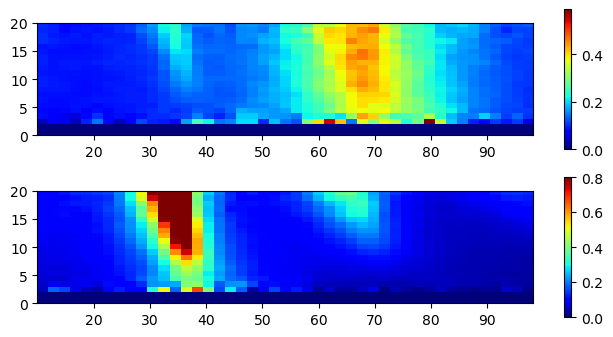

In [195]:
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(psd_align_summary[0], origin="lower", cmap="jet", extent=(fpsd[0], fpsd[-1], 0, nbin-1))
plt.colorbar()

plt.subplot(212)
plt.imshow(psd_align_summary[1], origin="lower", cmap="jet", extent=(fpsd[0], fpsd[-1], 0, nbin-1), vmin=0, vmax=0.8)
plt.colorbar()

plt.show()

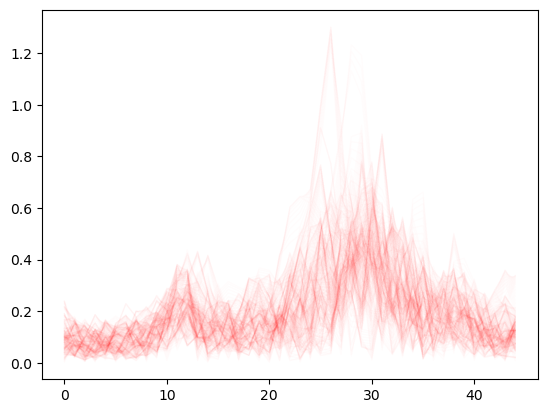

In [196]:
plt.figure()
plt.plot(psd_align[0][-1], lw=1, alpha=0.01, color='r')
plt.show()